In [25]:
import importlib
import sys

import numpy as np

# Force reload to avoid stale objects
if 'symbolic_bounds' in sys.modules:
    for mod in list(sys.modules.keys()):
        if mod.startswith('symbolic_bounds'):
            del sys.modules[mod]

from symbolic_bounds import DAG, DataGenerator, SCM, ProgramFactory
from symbolic_bounds.random_dag_generator import generate_random_partitioned_dag
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


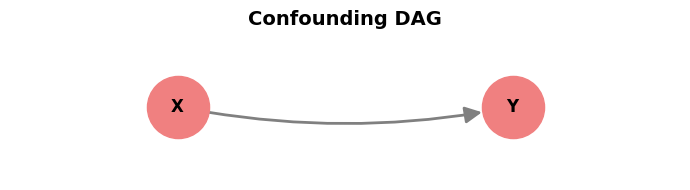

In [32]:
# 1. Generate a confounding DAG
dag = DAG()
X = dag.add_node('X', support={0, 1})
Y = dag.add_node('Y', support={0, 1})
# L0 = dag.add_node('L0', support={0, 1}, partition='L')
dag.add_edge(X, Y)

fig = dag.draw(figsize=(7, 2), title="Confounding DAG", with_labels=True)
plt.show()


In [27]:
dag.generate_all_response_types()
dag.print_response_type_table(X)
dag.print_response_type_table(Y)


Response types for X (no parents):
r_X^1: X = 0
r_X^2: X = 1


Response types for Y (parents: X):
=====

r_Y^1:
X | Y
-----
0 | 0
1 | 0

r_Y^2:
X | Y
-----
0 | 0
1 | 1

r_Y^3:
X | Y
-----
0 | 1
1 | 0

r_Y^4:
X | Y
-----
0 | 1
1 | 1



In [28]:
# 3. Generate Data
generator = DataGenerator(dag, seed=234)
joint = generator.computeObservedJoint() #Dict[FrozenSet[Tuple[Node, int]], float]
p11 = joint.get(frozenset({(X, 1), (Y, 1)}))
p10 = joint.get(frozenset({(X, 1), (Y, 0)}))
generator.print_true_distribution()
print(f'The known tian pearl bounds: [{p11:.4f}, {1-p10:.4f}] for P(Y=1 | do(X=1))')


TRUE RESPONSE TYPE DISTRIBUTION

Node: X
----------------------------------------
  P(R_X = 0) = 0.190930
  P(R_X = 1) = 0.809070
  Total: 1.000000

Node: Y
----------------------------------------
  P(R_Y = [(X=0)→0, (X=1)→0]) = 0.005015
  P(R_Y = [(X=0)→0, (X=1)→1]) = 0.046779
  P(R_Y = [(X=0)→1, (X=1)→0]) = 0.388216
  P(R_Y = [(X=0)→1, (X=1)→1]) = 0.559990
  Total: 1.000000

The known tian pearl bounds: [0.4909, 0.6818] for P(Y=1 | do(X=1))


In [30]:
# 4. Create SCM
scm = SCM(dag, generator)

lp = ProgramFactory.write_LP(scm, Y={Y}, X={X}, Y_values=(1,), X_values=(1,))

lp.is_minimization = True
# lp.print_decision_variables()
# lp.print_objective()

lb = lp.solve_model(verbose=False).evaluate_objective(np.array([1]))

lp.is_minimization = False
ub = lp.solve_model(verbose=False).evaluate_objective(np.array([1]))
print(f"\nEstimated bounds for P(Y=1 | do(X=1)): [{lb:.6f}, {ub:.6f}]")


Estimated bounds for P(Y=1 | do(X=1)): [0.490918, -0.681848]
